# Create a GW170817 C02 Glitch Removed Frame

## Set up notebook

In [1]:
import sys
from matplotlib import pyplot as plt
from matplotlib import rcParams

In [2]:
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize']=(14, 10)

In [3]:
import numpy as np
import pycbc.types
import pycbc.frame

In [4]:
gw170817_t = 1187008882.4

## Read in the BayesWave model of the glitch

In [5]:
glitch_data = pycbc.frame.read_frame(
    'L-L1_CLEANED_HOFT_C02_T1700406_v3-1187008667-4096.gwf',
    'L1:DCH-CLEAN_STRAIN_C02_glitch')

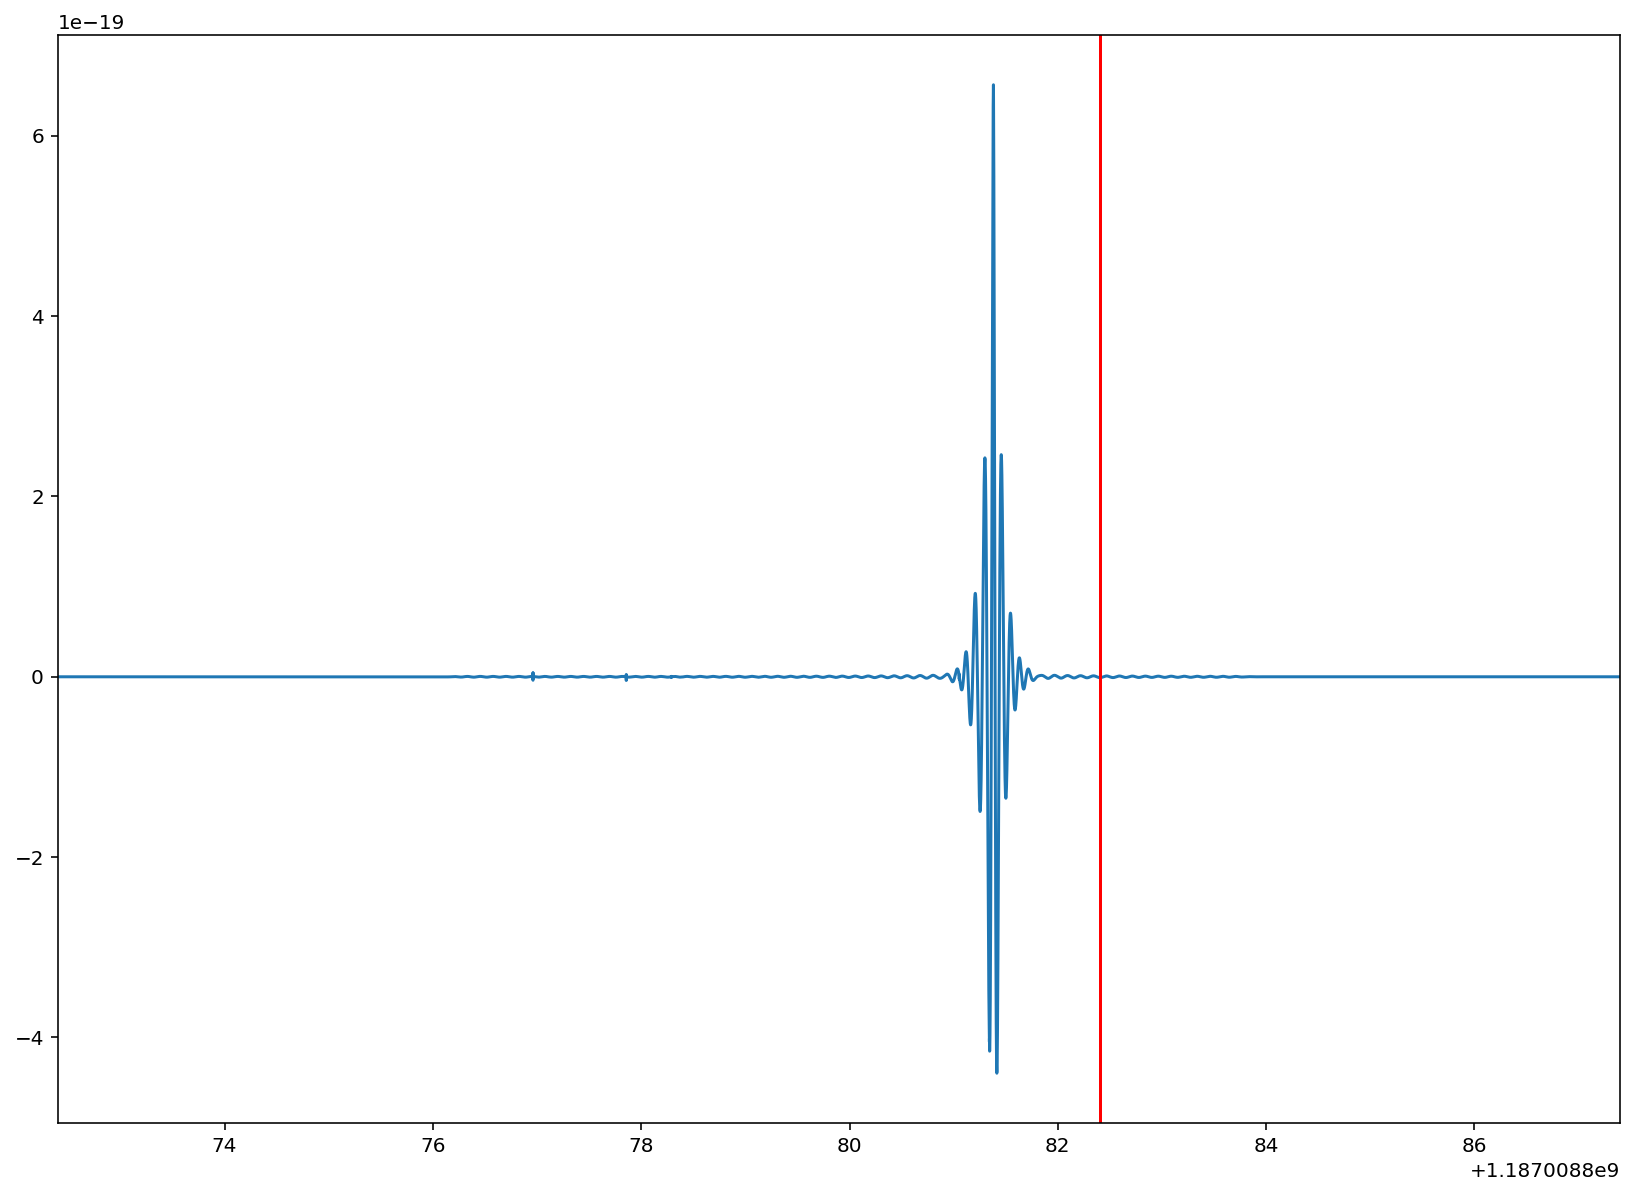

In [6]:
plt.plot(glitch_data.sample_times, glitch_data)
plt.xlim([gw170817_t-10,gw170817_t+5])
plt.axvline(gw170817_t, color='r')
plt.show()

## Read in the C02 cleaned GWOSC frame that contains the glitch

In [7]:
strain_data = pycbc.frame.read_frame(
    'L-L1_GWOSC_16KHZ_R1-1187006835-4096.gwf',
    'L1:GWOSC-16KHZ_R1_STRAIN')

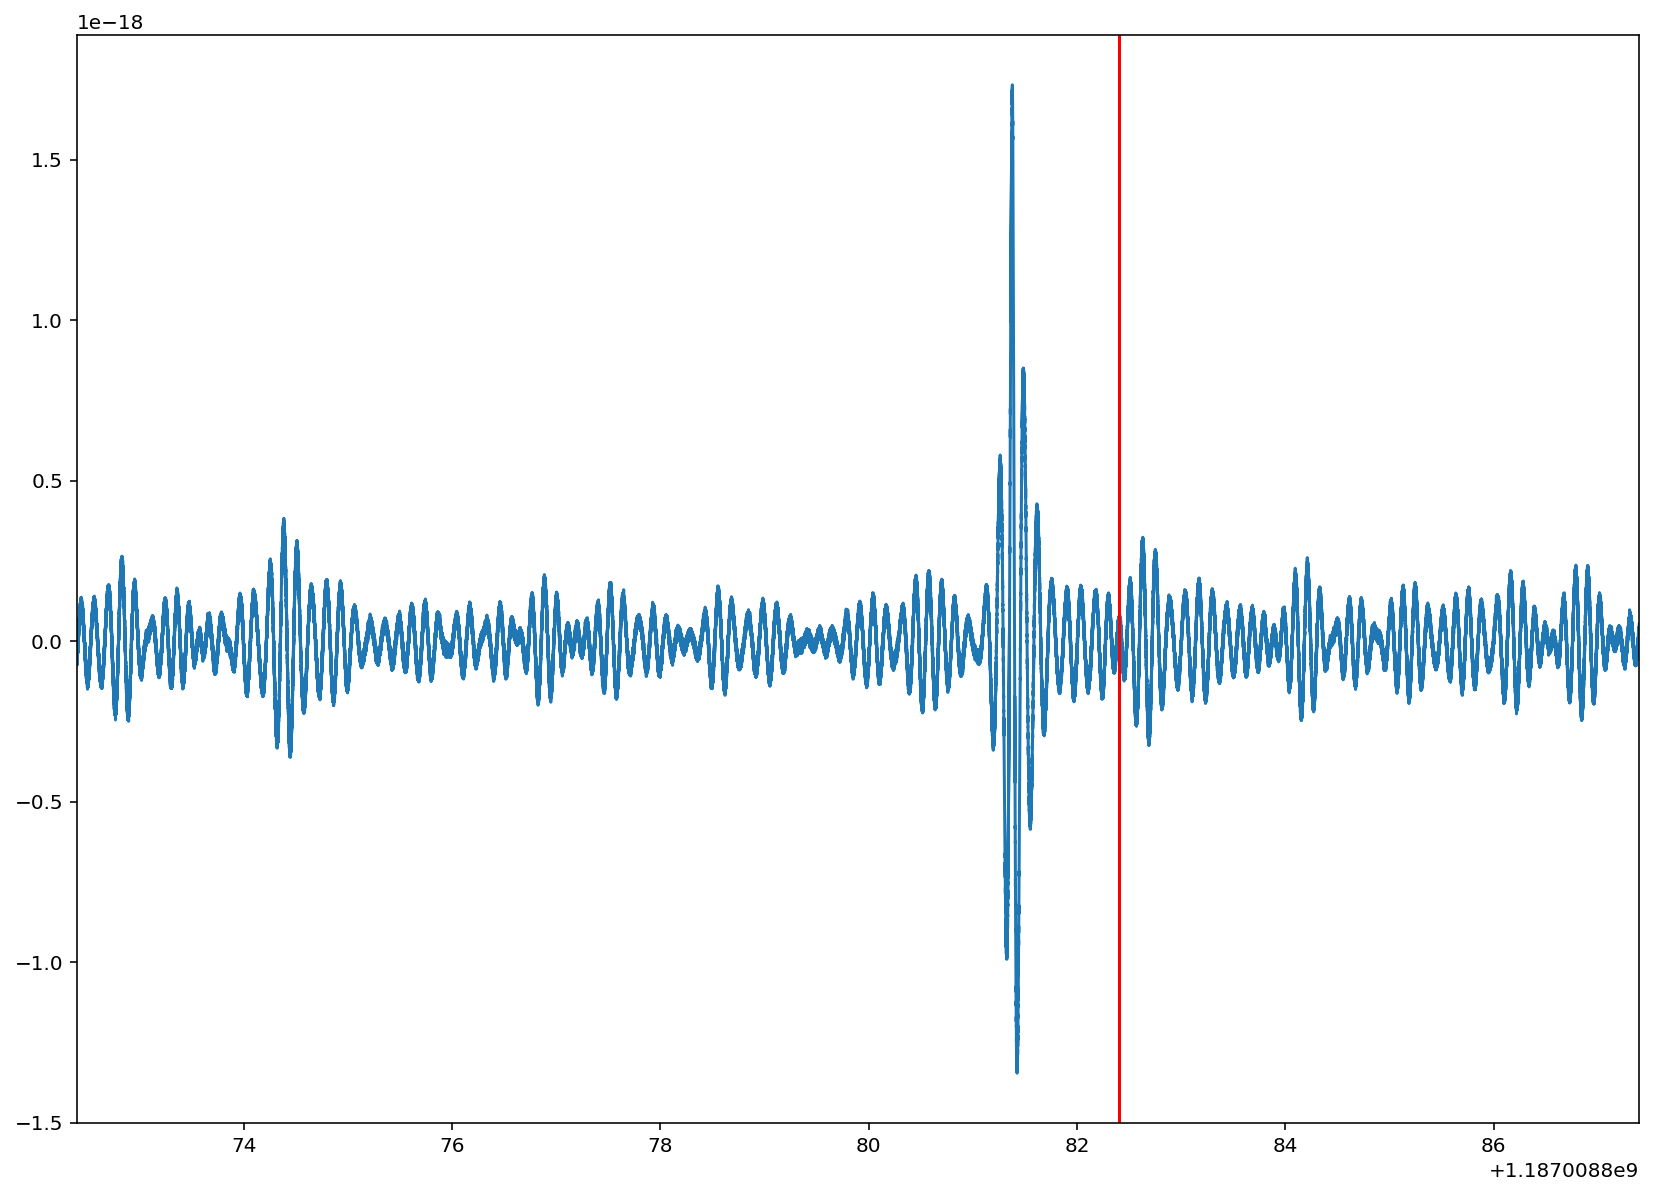

In [8]:
plt.plot(strain_data.sample_times, strain_data)
plt.xlim([gw170817_t-10,gw170817_t+5])
plt.axvline(gw170817_t, color='r')
plt.show()

## Subtract the glitch from the cleaned C02 data

The GWOSC frame does not overlap with the T1700406 frame, so we need to add zeros so that we can subtract them. The start and and times of the original frames are:

In [9]:
print strain_data.start_time, strain_data.end_time
print glitch_data.start_time, glitch_data.end_time

1187006835 1187010931
1187008667 1187012763


In [10]:
glitch_data.prepend_zeros(int(glitch_data.sample_rate*(glitch_data.start_time-strain_data.start_time)))

In [11]:
strain_data.append_zeros(int(strain_data.sample_rate*(glitch_data.end_time-strain_data.end_time)))

The start and end times of the frames now match, so we can subtract them:

In [12]:
print strain_data.start_time, strain_data.end_time
print glitch_data.start_time, glitch_data.end_time

1187006835 1187012763
1187006835 1187012763


In [13]:
glitch_removed_strain = strain_data - glitch_data

We slice the glitch-removed strain back down to the 4096 seconds in the original frame.

In [14]:
glitch_removed_strain = glitch_removed_strain.time_slice(1187006835, 1187006835+4096)

Now we remove old data to save memory.

In [15]:
del strain_data
del glitch_data
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


## Plot the glitch-removed C02 data around the time of GW170817

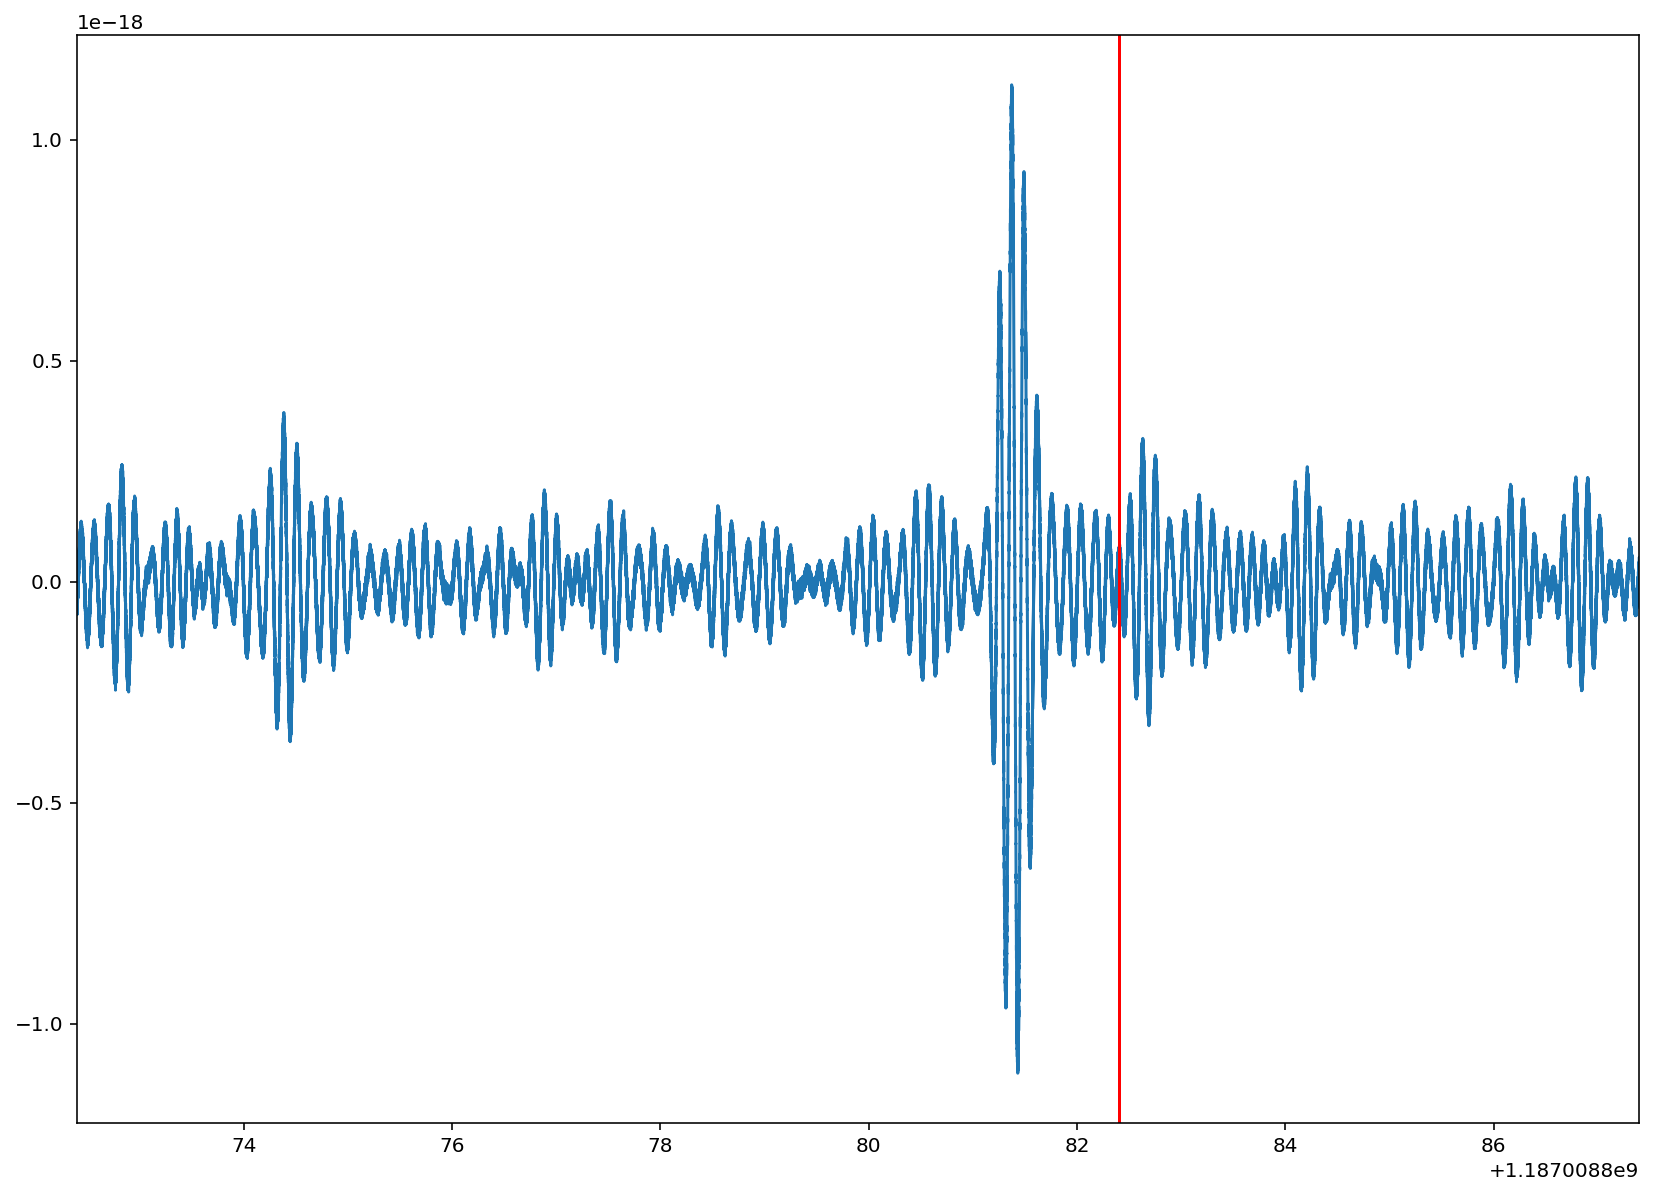

In [16]:
plt.plot(glitch_removed_strain.sample_times, glitch_removed_strain)
plt.xlim([gw170817_t-10,gw170817_t+5])
plt.axvline(gw170817_t, color='r')
plt.show()

## Compare to the LIGO glitch-removed data

We read in the glitch removed data from the LIGO frame and then subtract it from the data that we have created. These frames don't line up in time, so we slice them so they can be subtracted.

In [17]:
T1700406_data = pycbc.frame.read_frame(
    'L-L1_CLEANED_HOFT_C02_T1700406_v3-1187008667-4096.gwf',
    'L1:DCH-CLEAN_STRAIN_C02_T1700406_v3')

In [18]:
print T1700406_data.start_time, T1700406_data.end_time
print glitch_removed_strain.start_time, glitch_removed_strain.end_time

1187008667 1187012763
1187006835 1187010931


In [19]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


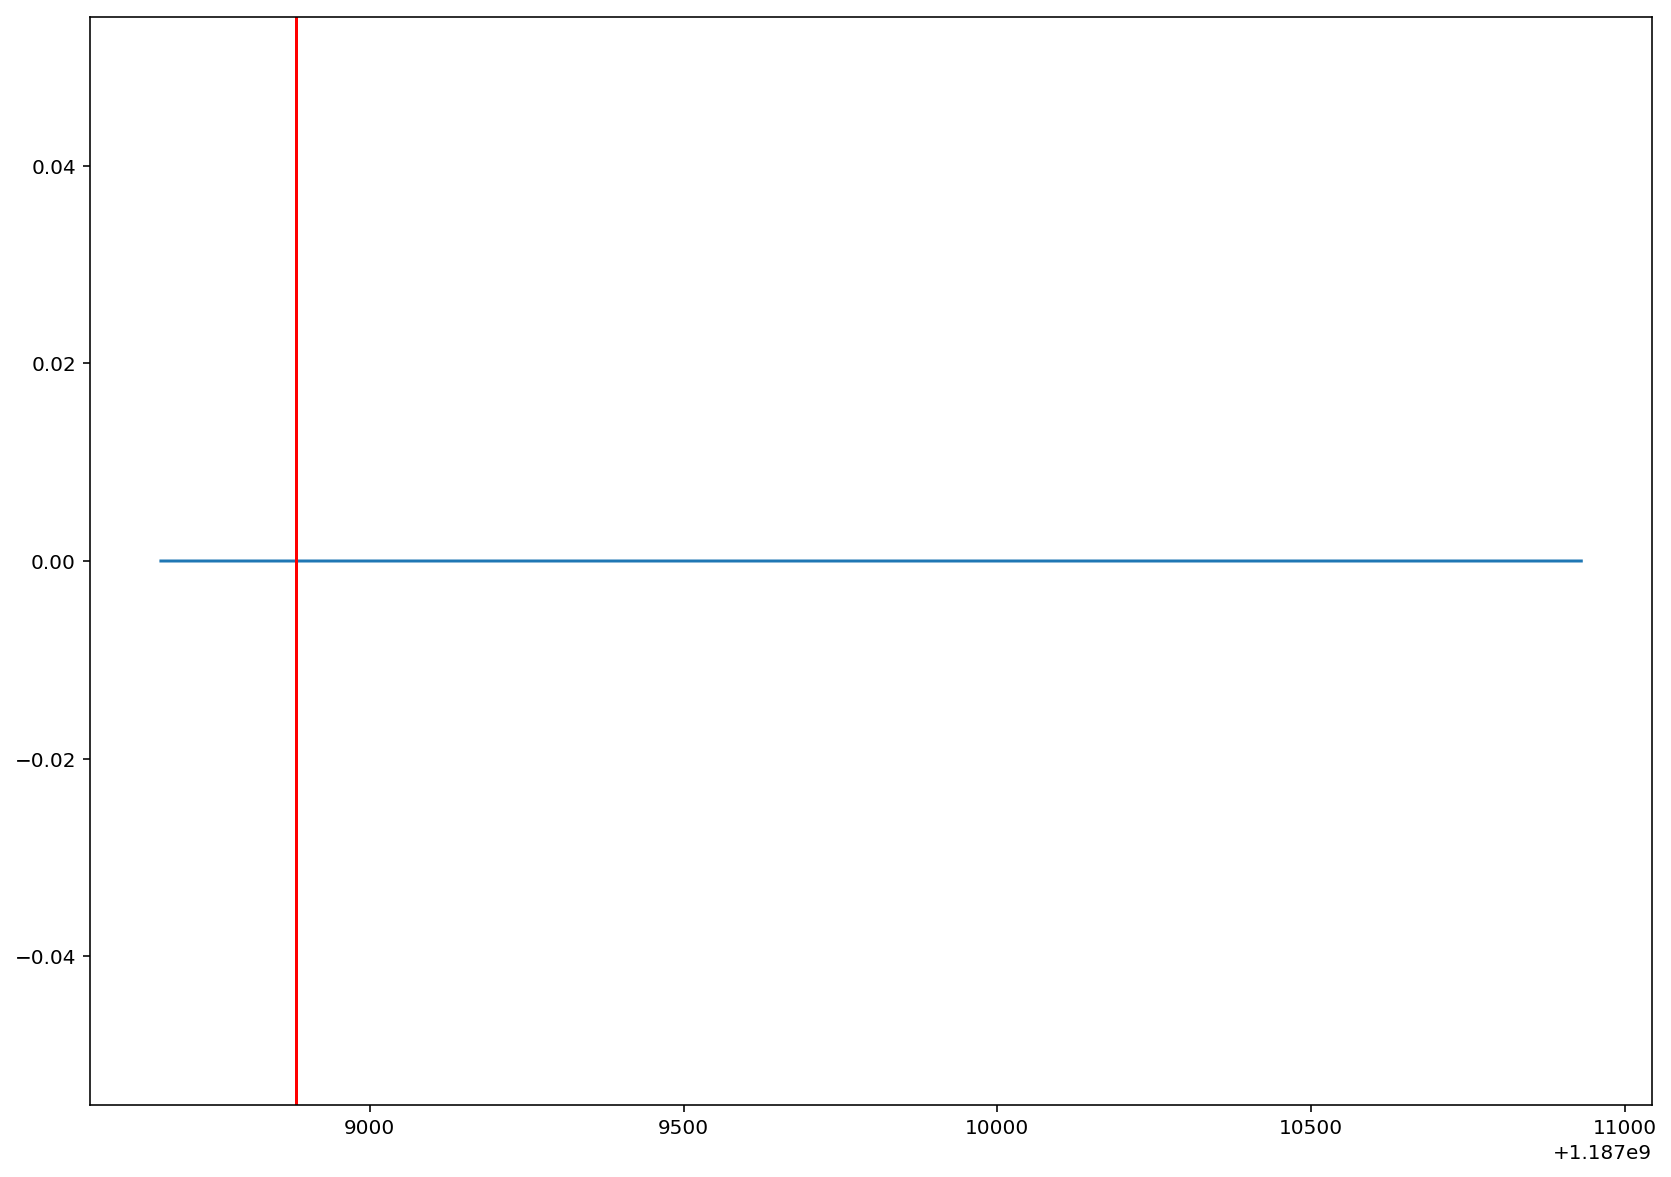

In [20]:
strain_diff = (T1700406_data.time_slice(T1700406_data.start_time,
                                       glitch_removed_strain.end_time) - 
              glitch_removed_strain.time_slice(T1700406_data.start_time,
                                       glitch_removed_strain.end_time))
plt.plot(strain_diff.sample_times, strain_diff)
plt.axvline(gw170817_t, color='r')
plt.show()

Check that the difference vetor is zero

In [21]:
print strain_diff.min(), strain_diff.max()

0.0 0.0


## Write the frame to disk

In [22]:
del strain_diff
del T1700406_data
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


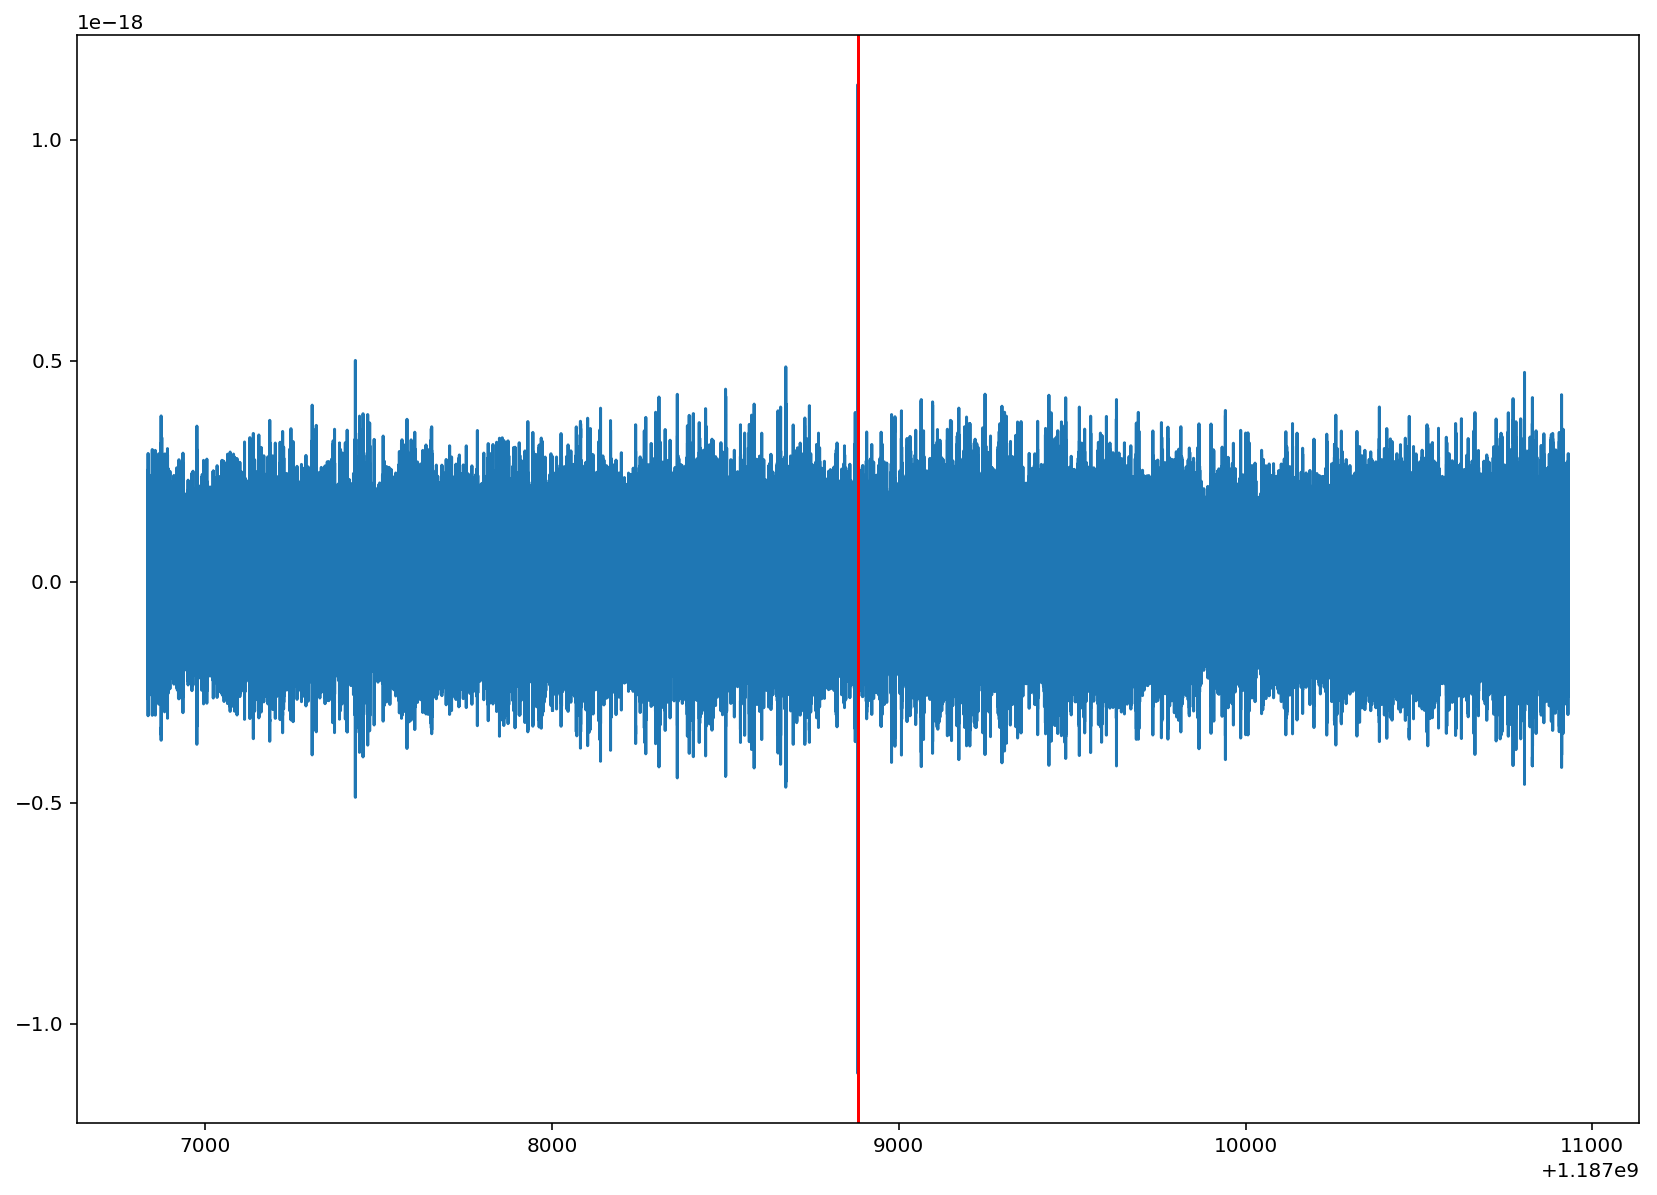

In [23]:
plt.plot(glitch_removed_strain.sample_times, glitch_removed_strain)
plt.axvline(gw170817_t, color='r')
plt.show()

In [24]:
print glitch_removed_strain.end_time - glitch_removed_strain.start_time

4096


In [25]:
pycbc.frame.write_frame('L-L1_GWOSC_16KHZ_R1_GLITCH_REMOVED-1187006835-4096.gwf',
    'L1:GWOSC-16KHZ_R1_STRAIN',glitch_removed_strain)

## Read the frame back in and make a time-frequency spectrogram

In [26]:
del glitch_removed_strain
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (0 entries)


In [27]:
rough_time = 1187008882
start = rough_time - 112
end = rough_time +  32
epoch = 1187008882.440
rough_chirplen = 3.455787e+02

In [28]:
frame = {}
frame['L1'] = ('L-L1_GWOSC_16KHZ_R1_GLITCH_REMOVED-1187006835-4096.gwf', 'L1:GWOSC-16KHZ_R1_STRAIN')

In [29]:
data = {}

for f in frame:
    file_name, channel = frame[f]
    sys.stdout.write("Reading {} from {}... ".format(channel, file_name))
    sys.stdout.flush()
    data[f] = pycbc.frame.read_frame(file_name, channel, start_time=start, end_time=end).astype(np.float64)
    sys.stdout.write('Done.\n')

Reading L1:GWOSC-16KHZ_R1_STRAIN from L-L1_GWOSC_16KHZ_R1_GLITCH_REMOVED-1187006835-4096.gwf... Done.


In [30]:
whitened_data = {}
slice_data = {}
scan_data = {}
for f in frame.keys():
    file_name, channel = frame[f]
    sys.stdout.write("Making qscan for {} from {}... ".format(channel, file_name))
    sys.stdout.flush()
    whitened_data[f] = data[f].whiten(8,8)
    del data[f]
    slice_data[f] = whitened_data[f].time_slice(rough_time - 100, rough_time + 4)
    scan_data[f] = {}
    scan_data[f]['times'], scan_data[f]['freqs'], scan_data[f]['p'] = slice_data[f].qtransform(
        .005, .25, frange=(25, 512), qrange=(110, 110))
    del slice_data[f]
    sys.stdout.write('Done.\n')

Making qscan for L1:GWOSC-16KHZ_R1_STRAIN from L-L1_GWOSC_16KHZ_R1_GLITCH_REMOVED-1187006835-4096.gwf... Done.


In [31]:
for f in frame.keys():
    scan_data[f]['relative_time'] = scan_data[f]['times'] - rough_time
    scan_data[f]['merger_time'] = scan_data[f]['times'] - epoch
    scan_data[f]['a'] = scan_data[f]['p']**0.5 * (2.0/(np.pi**0.5))

In [35]:
cmap = plt.get_cmap('viridis')

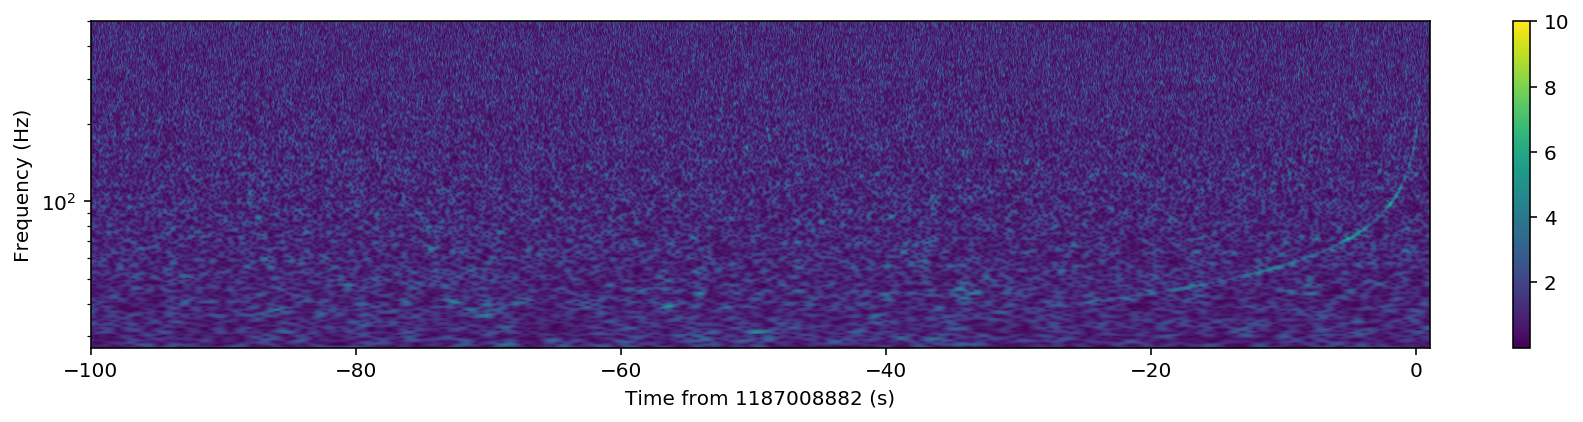

In [36]:
for f in frame.keys():
    plt.figure(figsize=[15, 3])
    plt.pcolormesh(scan_data[f]['relative_time'], scan_data[f]['freqs'], scan_data[f]['a'], vmax=10, cmap=cmap)
    plt.yscale('log')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time from {} (s)'.format(rough_time))
    plt.colorbar()
    plt.xlim(-100, 1)
    plt.ylim(27,500)
    plt.show()